# Cogs 108 - Final Project: What factors are most critical to Airbnb ratings?

## OVERVIEW
In this project, we explored what are the key factors keeping an Airbnb listing in Manhattan, New York City from achieving a perfect customer review score from 1000 observations. It turns out that people pay more attention to their experience on customer services such as check-in process, home cleanliness, and accuracy of the unit's description. Failure in these aspects would very likely lead to the final review score going downhill.

## NAMES
- Huaming Chen
- Haojia Li
- Yue Xia
- Minghe Yang

## RESEARCH QUESTION
What shall Airbnb hosts in Manhattan, New York improve to their properties or services in order to receive higher customer review ratings?

## BACKGROUND & PRIOR WORK
Ever since August 2008 when Airbnb has launched, it has become one of the most popular platforms for people to choose where to stay when traveling to different places. Unlike hotels that have rigorous and standardized procedures to ensure living experience, the customer rating of Airbnb homes depends on various aspects an Airbnb host can provide to their customer, whether they have necessary amenities, relatively good value, good service attitude, etc. Airbnb reviews are essential to hosts and Airbnb investors in the way that they help increase the occupancy rates, which would “generate traffic and increase their rental property’s rank on the site”, and thus will allow them to “leverage to charge higher rent to make more rental income”. (Reference 1). 

Previously, Dr.Tarik Dogru and Dr.Osman Pekin have conducted a data science research project focusing on, "what do guests value most in Airbnb accommodations?" And their finding at the end is that, "the results of our study showed that Airbnb guests place more value on space, cleanliness, number of photos, handicap accessibility, family friendliness, free breakfast, location, and unique experiences." (Reference 2) which gives us a good hint of what to expect from our results.

References:
    
    1.The link that explains why Airbnb reviews are important 
    https://www.mashvisor.com/blog/airbnb-reviews-of-guests-important/
    2. Data Science research project conducted by Dr.Tarik Dogru and Dr.Osman Pekin
    https://www.bu.edu/bhr/2017/06/07/airbnb-guest-pricing-value/

## HYPOTHESIS
Instead of customer services, Airbnb hosts in Manhattan, NY should emphasize particularly on their in-unit amenities to improve their customer rating to a perfect score because we think better amenities can very easily improve customers' overall impression and living experience.

## DATASET
- Variables:  Host Response Rate, Host Response Time, Amenities,  Number of Reviews, Review Scores Rating, Review Score of Accuracy, Review Score of Cleanliness, Review Scores Checkin, Cancellation Policy 
- Observation:  Randomly selected 1000 Airbnb listings in Manhattan, NYC from 10530 total observations valid
- Who/what/how: The data are the open listing data of Airbnb, the dataset includes all the information about the listing, but we only keep the variables that matter the most to the customer rating, eliminating the minor factors such as accommodate and the time since the property started doing Airbnb. We also get rid of the personal information about the host, making sure that the hosts have their privacy secured.
 
- Data stored: Data collected would be stored in CSV format.
- Original dataset: https://public.opendatasoft.com/explore/dataset/airbnb-listings/table/?disjunctive.host_verifications&disjunctive.amenities&disjunctive.features&refine.city=New+York

### Setup
Initial setup for essential packages.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import patsy
import statsmodels.api as sm
import seaborn as sns; sns.set(style="white", font_scale=2)
import matplotlib.pyplot as plt

# scikit-learn imports
#   SVM (Support Vector Machine) classifer 
from sklearn.svm import SVC
from sklearn.metrics import classification_report, precision_recall_fscore_support

Read in the dataset and only keep the seemingly relevant features.

In [2]:
df = pd.read_csv("Project_Data/airbnb-listings.csv", sep = ';', low_memory=False)

In [3]:
df = df[['Neighbourhood Group Cleansed',
    'Host Response Rate',
    'Host Response Time',
    'Amenities',
   'Number of Reviews',
   'Review Scores Rating',
   'Review Scores Accuracy',
   'Review Scores Cleanliness',
   'Review Scores Checkin',
   'Cancellation Policy']]

## DATA CLEANING

Remove out all rows with missing values.

In [4]:
df = df.dropna(axis='rows')

Now we don't have any missing values in the dataframe.

In [5]:
df.isnull().any().sum()

0

We only want to focus on listings in Manhattan, so remove all listing records which are not located in Manhattan.

In [6]:
indexNames = df[df['Neighbourhood Group Cleansed'] != 'Manhattan'].index
df.drop(indexNames, inplace = True)

Delete the Neighbourhood column since we only have listings in Manhattan now.

In [7]:
df = df.drop(['Neighbourhood Group Cleansed'], axis=1) 

Use a displot to visually check the distribution of the remaining listings.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


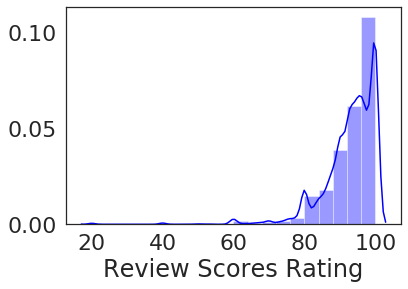

In [8]:
sns.distplot(df["Review Scores Rating"], bins = 20, color = "blue")

Save the dataframe as ML_df for later use to check the correctness of our findings.

In [9]:
ML_df = df

Transform cancellation flexibility levels into their numeric representations. The greater the number, the flexible for cancellation: 
- 33.3: strict
- 66.6: moderate
- 100.0: flexible

Note: this transformation might result in potential bias of the data to be analyzed.

In [10]:
def parseCancel(string):
    string = str(string)
    if 'strict' in string:
        return 33.3
    if 'moderate' in string:
        return 66.6
    if 'flexible' in string:
        return 100.0


Apply the parseCancel function to the existing dataframe.

In [11]:
df['Cancellation Flexibility'] = df['Cancellation Policy'].apply(parseCancel)

Transform host response time levels into their numeric representations. The greater the number, the faster the respond time.
- 100.0: within an hour
- 75.0: within a few hours
- 50.0: a day
- 25.0: few days

Note: this transformation might result in potential bias of the data to be analyzed.

In [12]:
def parseTime(string):
    if 'within an hour' in string:
        return 100.0
    if 'within a few hours' in string:
        return 75.0
    if 'a day' in string:
        return 50.0
    if 'few days' in string:
        return 25.0

Apply the parseTime function to the existing dataframe.

In [13]:
df['Res_Level'] = df['Host Response Time'].apply(parseTime)

Scale up accuracy, cleanliness, and checkin values into floating numbers in 100 basis.

In [14]:
df['Review Scores Accuracy']  = df['Review Scores Accuracy']  * 10
df['Review Scores Cleanliness']  = df['Review Scores Cleanliness']  * 10
df['Review Scores Checkin']  = df['Review Scores Checkin']  * 10

To ensure sample varaibility, randomly select 1000 observations from the remaining 10530 listings.

In [15]:
df = df.sample(n = 1000)

Rename some of the columns to make the dataframe looks cleaner and erase the blank space.

In [16]:
df = df.rename(columns={"Host Response Rate": "Response_Rate",
                   "Host Response Time": "Response Time",
                  "Number of Reviews" : "Reviews",
                  "Review Scores Rating" : "Rating",
                  "Review Scores Accuracy" : "Accuracy",
                  "Review Scores Cleanliness" : "Cleanliness",
                  "Review Scores Checkin" : "Checkin",
                  "Cancellation Flexibility": "Cancellation_Flexibility"})

#reset index
df =df.reset_index(drop=True)
df.head()

,Response_Rate,Response Time,Amenities,Reviews,Rating,Accuracy,Cleanliness,Checkin,Cancellation Policy,Cancellation_Flexibility,Res_Level
0,98.0,within a few hours,"Wireless Internet,Kitchen,Heating,Washer,Dryer...",12,87.0,90.0,90.0,100.0,strict,33.3,75.0
1,100.0,within a few hours,"TV,Internet,Wireless Internet,Air conditioning...",14,93.0,90.0,90.0,90.0,strict,33.3,75.0
2,100.0,within an hour,"TV,Cable TV,Internet,Wireless Internet,Air con...",8,98.0,100.0,100.0,100.0,moderate,66.6,100.0
3,100.0,within an hour,"Internet,Wireless Internet,Air conditioning,Ki...",84,85.0,90.0,80.0,90.0,strict,33.3,100.0
4,88.0,within an hour,"TV,Cable TV,Wireless Internet,Air conditioning...",9,90.0,100.0,80.0,100.0,flexible,100.0,100.0


In [17]:
#Drop 'Response Rate' and 'Cancellation Policy' because they already have new corresponding columns as their numerical representations.
#Drop 'Reviews' column for data cleanliness.
df = df.drop(['Response Time', 'Reviews', 'Cancellation Policy'], axis=1) 


Note: since our observations were chosen randomly, some listings might have significantly less number of reviews than others. We didn't take this into account in our final data analysis step. <br/>





Since there are too many unique items in Amenities column, we chose to parse these values from string to numerical floating numbers. We splitted potential amenities into three common categories as `*necessity, safety, and entertainment.*` For each subcategory, we checked if there was a missing essential item and we deducted its corresponding score if there was.

Note: we might have potential bias when doing this transformation because we have manually defined which items are supposedly common. The formula we used to calculate how much scores to deduct is: `40 / (# of common items) * (# of missing items)`. Due to enormous varieties of unique amenities combinations, it is not feasible to deduct all score if missing all of our predefined "common items." So, we chose to let the listing have at least 60 points in each subcategory.

In [18]:
def parseNecessity(string):
    score = 100.0
    if "Essential" not in string:
        score -= 8.0
    if "Air conditioning" not in string:
        score -= 8.0
    if "Kitchen" not in string:
        score -= 8.0
    if "Washer" or "Dryer" not in string:
        score -= 8.0
    if "Heating" not in string:
        score -= 8.0
    return score
        
def parseSafety(string):
    score = 100.0
    if "Smoke detector" not in string:
        score -= 10.0
    if "Carbon monoxide" not in string:
        score -= 10.0
    if "Fire extinguisher" not in string:
        score -= 10.0
    if "First aid kit" not in string:
        score -= 10.0
    return score

def parseEntertainment(string):
    score = 100.0
    if "TV" not in string:
        score -= 20.0
    if "Internet" not in string:
        score -= 20.0
    return score

Apply our functions to transform the Amenities column into three different columns in numbers.

In [19]:
df['Necessities'] = df['Amenities'].apply(parseNecessity)
df['Safety'] = df['Amenities'].apply(parseSafety)
df['Entertainment'] = df['Amenities'].apply(parseEntertainment)

"Amenities" column is no longer needed, drop it from the dataframe. To cope with common human habits when reading dataframes, we moved the "Rating" column to the right and renamed as "Ratings."

In [20]:
df = ((df.drop(['Amenities'], axis=1)).assign(Ratings = df['Rating'])).drop(['Rating'], axis=1)

Data cleaning finished.

Display the dataframe.

In [21]:
df.head()

,Response_Rate,Accuracy,Cleanliness,Checkin,Cancellation_Flexibility,Res_Level,Necessities,Safety,Entertainment,Ratings
0,98.0,90.0,90.0,100.0,33.3,75.0,84.0,80.0,80.0,87.0
1,100.0,90.0,90.0,90.0,33.3,75.0,92.0,60.0,100.0,93.0
2,100.0,100.0,100.0,100.0,66.6,100.0,92.0,90.0,100.0,98.0
3,100.0,90.0,80.0,90.0,33.3,100.0,92.0,100.0,80.0,85.0
4,88.0,100.0,80.0,100.0,100.0,100.0,84.0,80.0,100.0,90.0


## DATA VISUALIZATION

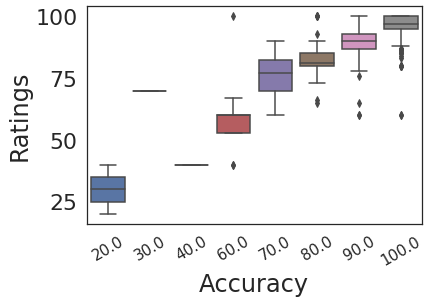

In [22]:
ax = sns.boxplot(x='Accuracy', y = 'Ratings', data = df)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 30, fontsize = 15);

This graph shows that there is a strong correlation between the description accuracy and the customer review rating with some acceptible amount of outlier observations.

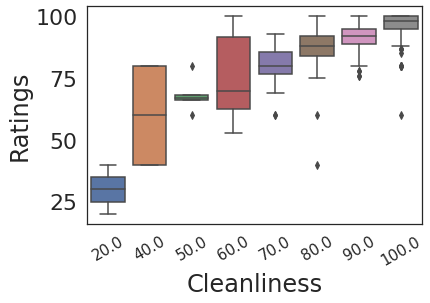

In [23]:
ax = sns.boxplot(x='Cleanliness', y = 'Ratings', data = df)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 30, fontsize = 15);

This graph shows that there is a strong correlation between the cleanliness and the customer review rating with some acceptible amount of outlier observations.

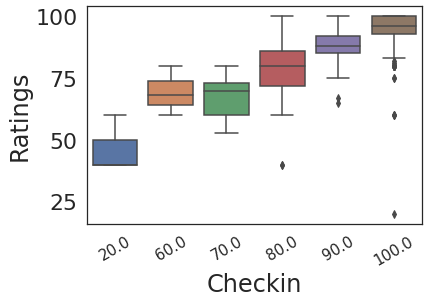

In [24]:
ax = sns.boxplot(x='Checkin', y = 'Ratings', data = df)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 30, fontsize = 15);

This graph shows that there is a relatively weaker correlation between the check-in convenience and safety and the customer review rating with some acceptible amount of outlier observations, but there is still an obvious correlation.

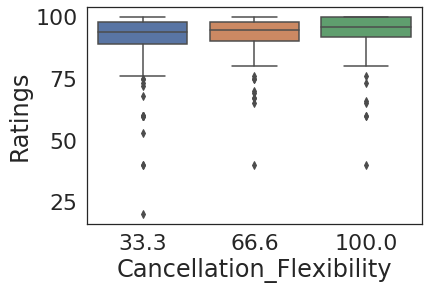

In [25]:
sns.boxplot(x='Cancellation_Flexibility', y = 'Ratings', data = df)

This graph shows that there is a week correlation between the cancellation_Flexibility and the customer review rating with some acceptible amount of outlier observations, we can tell from the graph that the IQR and mean value for the customer ratings from the three cancellation_flexibility values are nearly the same.

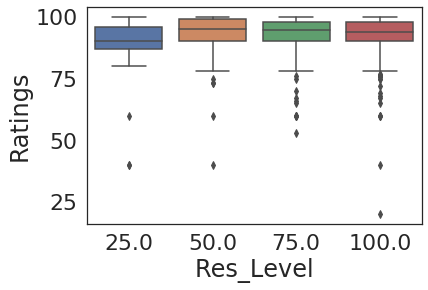

In [26]:
sns.boxplot(x='Res_Level', y = 'Ratings', data = df)

Similar to the relationship between rating and cancellation_Flexibility, this boxplot above shows that there is a week correlation between the host response time (Res_Level) and the customer review rating, with some acceptible amount of outlier observations, the final rating has very similar IQR and mean at different response time.

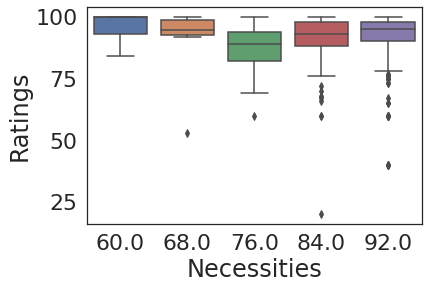

In [27]:
sns.boxplot(x='Necessities', y = 'Ratings', data = df)

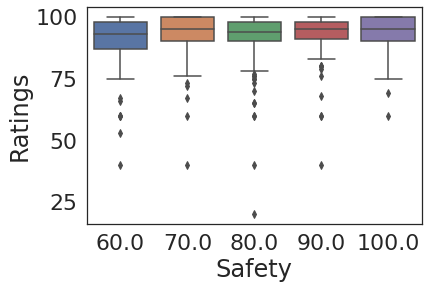

In [28]:
sns.boxplot(x='Safety', y = 'Ratings', data = df)

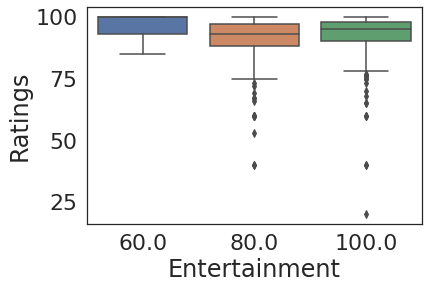

In [29]:
sns.boxplot(x='Entertainment', y = 'Ratings', data = df)

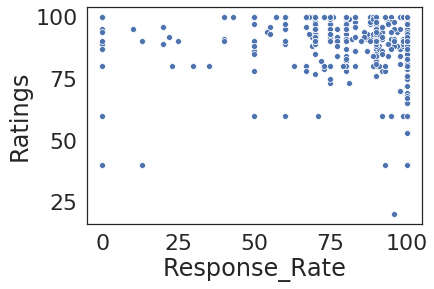

In [30]:
sns.scatterplot(x = df['Response_Rate'], y = df['Ratings'])

Given the massive and variate data for the reponse_rate variable, scatterplot helps us better to visualize the distribution of the data compared to boxplot.

For the same reasonings as above, these three graphs concerning about the relationship between amenities and customer rating show that the correlation between those factors and the final rating result is weak.

## DATA ANALYSIS & RESULTS

In [31]:
# Create a multi-linear model to predict customer ratings from all the factors. 
# Use patsy.dmatrices to create the design matrices, calling the outputs outcome, predictors
outcome, predictors = patsy.dmatrices('Ratings ~ Response_Rate + Accuracy  + Cleanliness + Checkin + Cancellation_Flexibility + Res_Level + Necessities + Safety + Entertainment', df)

# Create an OLS model using 'outcome' and 'predictors'
mod = sm.OLS(outcome, predictors)

# Use the data we have to fit the newly-created model, assigning it to `res_2`.
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                Ratings   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     289.9
Date:                Wed, 10 Jun 2020   Prob (F-statistic):          2.44e-270
Time:                        09:47:45   Log-Likelihood:                -2886.2
No. Observations:                1000   AIC:                             5792.
Df Residuals:                     990   BIC:                             5841.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

From the multi-linear regression model above, we can see that among all the explainatory variables, the coefficient for 'Accuracy', 'Cleanliness', and 'Checkin' are much greater than the other factors, and their p-value is small, which means that they are statistically significant to the customer rating result.

In [32]:
# Create a correlation matrix, only keep the column which contains the correlation coefficient of the explainatory 
# variables and the ratings, then remove the row that calculates the correlation coefficient of rating and itself.
corrs = df.corr()['Ratings'].to_frame().drop(['Ratings'], axis = 0)

# Rearrange the values in descending order to check out which explainatory variables are most related to ratings
corrs.sort_values("Ratings", inplace = True, ascending = False) 
corrs

,Ratings
Accuracy,0.765501
Cleanliness,0.714985
Checkin,0.631537
Response_Rate,0.121104
Entertainment,0.100432
Necessities,0.099782
Safety,0.094928
Cancellation_Flexibility,0.087958
Res_Level,0.020673


From the boxplots we did last part and the correlation coefficient we determined above, we can see that `'Cleanliness'`, `'Accuracy'`, and `'Checkin'` are the comparatively significant factors that contribute to final ratings.

In the data cleaning part, we define the original Manhattan dataset as ML_df, now we use it to do machine learning that will help us to predict the final ratings with `'Cleanliness'`, `'Accuracy'`, and `'Checkin'` levels.

In [33]:
ML_df = ML_df.rename(columns={"Review Scores Accuracy" : "Accuracy",
                  "Review Scores Cleanliness" : "Cleanliness",
                  "Review Scores Checkin" : "Checkin",
                  "Review Scores Rating" : "Ratings"}).drop(["Host Response Rate", 
                                                              "Host Response Time", 
                                                              "Amenities", 
                                                              "Number of Reviews", 
                                                              "Cancellation Policy",
                                                              "Cancellation Flexibility",
                                                              "Res_Level"], axis = 1)
ML_df

,Ratings,Accuracy,Cleanliness,Checkin
0,86.0,90.0,80.0,90.0
1,96.0,100.0,90.0,100.0
2,88.0,90.0,90.0,100.0
3,80.0,100.0,60.0,100.0
4,100.0,100.0,100.0,100.0
...,...,...,...,...
19518,95.0,100.0,90.0,100.0
19519,94.0,100.0,90.0,90.0
19521,96.0,100.0,90.0,100.0
19523,100.0,100.0,100.0,100.0


### Training

In [34]:
#if rating is equal to or greater than 90,  replace rating w/ 1.0, if less, replace w/ 0.0

ML_df.loc[(ML_df['Ratings'] < 90.0),'Ratings']= 0.0
ML_df.loc[(ML_df['Ratings'] >= 90.0),'Ratings']= 1.0

# Convert the 'Ratings' column in the dataframe into a numpy array
ratings_y = ML_df["Ratings"].to_numpy()

# Select 80% of the data as training data and 20% of the data as testing data
num_training = int(len(ratings_y) * 0.8)
num_testing = int(len(ratings_y) - num_training)

In [35]:
# Pull out the training dataset from ML_df, drop the row of rating, and convert it to a matrix
train_df = ML_df[:num_training].drop('Ratings', axis = 1).as_matrix()
test_df = ML_df[num_training:].drop('Ratings', axis = 1).as_matrix()

train_y = ratings_y[:num_training]
test_y = ratings_y[num_training:]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [36]:
# Define the supprot vector machine
def train_SVM(X, y, kernel='linear'):
    clf = SVC(kernel=kernel)
    clf.fit(X, y)
    return clf

In [37]:
clf = train_SVM(train_df, train_y)

### Prediction

In [38]:
#Predict the labels for both the training and test samples (the 'X' data).
predicted_train_y = clf.predict(train_df)
predicted_test_y = clf.predict(test_df)

In [39]:
# Print prediction report
print(classification_report(train_y,predicted_train_y))

              precision    recall  f1-score   support

         0.0       0.86      0.50      0.63      1949
         1.0       0.87      0.98      0.92      6802

    accuracy                           0.87      8751
   macro avg       0.86      0.74      0.78      8751
weighted avg       0.87      0.87      0.86      8751



In [40]:
# Print prediction report
print(classification_report(test_y,predicted_test_y))

              precision    recall  f1-score   support

         0.0       0.84      0.49      0.62       485
         1.0       0.87      0.97      0.92      1703

    accuracy                           0.87      2188
   macro avg       0.85      0.73      0.77      2188
weighted avg       0.86      0.87      0.85      2188



The precision percentage are all above 70%, which make our predictions valid. However, the result shows that the machine is better at predicting the houses/apartments that receive ratings higher than 90, rather than the ones that have ratings lower than 90.

## ETHICS & PRIVACY

###### Data Bias:  
We have only pick 1000 sample observations out of 10000
 
###### Consent:  
We collected data from the open listing of Airbnb hosts, so no sign for consent needed.
 
###### Data Privacy/Ownership: 
Datas are cited from those websites. We will get rid of the personal information of the host and the property when we are doing the data cleaning part of our project.
 
###### Transparency: 
Our dataset and algorithm are public.
 
###### Implications: 
The information gained and the tool we are building would not be co-opted for nefarious purposes since we are not using any private data. If our research leads to any unintended consequences, we would erase all the data collected.
 
###### Evaluation: 
Our project shall be considered successful if the most of the results aline with our hypothesis.
 
###### Continuous monitoring: 
We would be tracking for any changes related to our data and assumptions.

## CONCLUSION & DISCUSSION

Our result shows that 'Cleanliness', 'Accuracy', and 'CheckIn' are the most significant factors that affect the customer ratings for the Airbnb hosts in Manhattan, New York. Out of the three factors, two of them ('cleanliness' and 'check-in') are associated with customer service, and the remaining one 'Accuracy' is associated with the hardware facilities, thus, our research result tells us that Airbnb hosts should improve both their customer service and in-unit facilities,

## TEAM CONTRIBUTIONS / TIMELINE

| Meeting Date  | Meeting Time| Completed Before Meeting  | Discuss at Meeting |
|---|---|---|---|
| 4/17  |  1 PM | Brainstorm possible topics and discuss details about the research problem.  | Discuss and debate on final project topic; discuss hypothesis; begin background research | 
| 4/20  |  12 PM |  Narrowing research topic. Do background research to be more accurate in analyzing when conducting the research. | Looking at details of the topic and deciding which aspects are the most critical ones. | 
| 2/1  | 10 AM  | Edit, finalize, and submit proposal; Search for datasets  | Discuss Wrangling and possible analytical approaches; Assign group members to lead each specific part   |
| 4/20  | 12 PM  | Narrowing research topic. Do background research to be more accurate in analyzing when conducting the research. | Looking at details of the topic and deciding which aspects are the most critical ones.  |
| 4/22  | 3 PM  | Deciding which elements to be included in the research question. | Discuss on whose data are we collecting and how to construct our data graphs based on the elements that we pick(Variables, observations,.. etc) |
| 4/23  | 6 PM  | Deciding the final project.| Finalize project proposal with details.|
| 5/7  | 12 PM  | Edit, finalize, and submit proposal; Search for datasets | Looking for substantial and credible datasets.  |
| 5/14  | 12 PM  | Done researching for needed datasets. | Combine data sets and organize them into tidy data forms. Collect new data if needed. Import and wrangle data. |
| 5/21  | 12 PM  | Import & Wrangle Data | Continue to wrangle and organize data, and discuss how to use data visualization possible analytical approaches.|
| 5/28  | 7 PM  |Import & Wrangle Data (Minghe $ Haojia); Data Visualization (Huaming & Yue)| Review/Edit wrangling; Use data visualization to discuss Analysis Plan |
| 6/3  | 12 PM  | Finalize wrangling; Begin Analysis| Discuss/edit Analysis; Complete project check-in;Complete analysis; Draft results/conclusion/discussion |
| 6/10  | Before 11:59 PM  | NA | Turn in Final Project & Group Project Surveys |

